# CP490 B02 Project <br>
โดย<br>
64102010077 ธนิสร ธนาวิชญ์ <br>
64102010291 ณัชสุภา พุทธิวโรดม<br>
64102010292 ณัฐวุฒิ ขาวสะอาด<br>
64102010302 สริดา คงสุชาติ<br>

**Task:** Face detection and recognition

## 1. Describe the model: input-output
**เลือก Model แล้วอธิบาย Input-Output** <br>
เลือก Model เป็น facenet-pytorch <br>
Input เป็นภาพ หรือวิดีโอที่มีใบหน้าคน <br>
และ Output เป็นพิกัดตำแหน่งใบหน้า (สูง, กว้าง, พิกัดจุด x, พิกัดจุด y) และตา จมูก ปาก (พิกัดจุด x, พิกัดจุด y) <br>
https://github.com/timesler/facenet-pytorch


## 2. Show the code for running the model
**จาก Model ที่เลือกไว้ที่ข้อ 1. ให้เขียน Code ใน Colab ที่รัน Model**

https://github.com/timesler/facenet-pytorch/blob/master/examples/infer.ipynb <br>
Code for accuracy check from https://machinelearningmastery.com/how-to-evaluate-the-performance-of-pytorch-models/

In [1]:
# With pip:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.1 MB/s eta 0:00:00


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


<h4>Define MTCNN module</h4>

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

<h4>Define Inception Resnet V1 module</h4>

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

<h4>Define a dataset and data loader</h4>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/drive/MyDrive/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<h4>Perfom MTCNN facial detection </h4>

In [8]:
aligned = []
names = []

for x, y in loader:
  x_aligned, prob = mtcnn(x, return_prob=True)
  y_pred = mtcnn(x)
  if x_aligned is not None:
    print('Face detected with probability: {:8f}'.format(prob))
    aligned.append(x_aligned)
    names.append(dataset.idx_to_class[y])

Face detected with probability: 0.998218
Face detected with probability: 0.999781
Face detected with probability: 0.994918
Face detected with probability: 0.998899
Face detected with probability: 0.990820
Face detected with probability: 0.999971
Face detected with probability: 0.999533
Face detected with probability: 0.999590
Face detected with probability: 0.999589
Face detected with probability: 0.998921
Face detected with probability: 0.999644
Face detected with probability: 0.998067
Face detected with probability: 0.998631
Face detected with probability: 0.976558
Face detected with probability: 0.972429
Face detected with probability: 0.998373
Face detected with probability: 0.998451
Face detected with probability: 0.997302
Face detected with probability: 0.999907
Face detected with probability: 0.989557


In [9]:
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, extract_face
import matplotlib.pyplot as plt

for x, y in loader:
  print(dataset.idx_to_class[y])
  mtcnn_draw = MTCNN(keep_all=True)
  boxes, probs, points = mtcnn_draw.detect(x, landmarks=True)
  # Draw boxes and save faces
  img_draw = x.copy()
  draw = ImageDraw.Draw(img_draw)
  for i, (box, point) in enumerate(zip(boxes, points)):
    draw.rectangle(box.tolist(), width=5)
    for p in point:
      draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
    extract_face(x, box, save_path='detected_face_{}.png'.format(i))
  plt.imshow(img_draw)
  plt.show()
  img_draw.save('annotated_faces.png')

Output hidden; open in https://colab.research.google.com to view.

<h4>Calculate image embeddings</h4>

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

<h4>Print distance matrix for classes</h4>

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
pd.DataFrame(dists, columns=names, index=names)

,Emmy,Emmy,Emmy,Emmy,Emmy,Fond,Fond,Fond,Fond,Fond,L,L,L,L,L,Nana,Nana,Nana,Nana,Nana
Emmy,0.000000,1.072759,0.814467,0.876285,0.641193,1.149584,1.205627,1.149063,1.227341,1.164365,0.857155,0.961001,0.934394,0.928160,0.810016,1.193355,1.221831,1.069059,1.338166,1.124599
Emmy,1.072759,0.000000,0.811446,0.824521,1.257987,1.218876,1.220571,1.138135,1.174944,1.227701,1.050381,1.103126,1.181856,1.107471,1.255313,0.954127,1.213017,1.184190,1.042938,1.205854
Emmy,0.814467,0.811446,0.000000,0.824947,0.866523,1.187173,1.185144,1.129752,1.271023,1.300188,0.896872,0.976061,1.147893,0.946110,1.117314,1.085191,1.209835,1.308900,1.298081,1.299188
Emmy,0.876285,0.824521,0.824947,0.000000,0.891668,1.117674,1.112030,1.108639,1.214223,1.243273,1.126114,1.206621,1.229572,0.999583,1.143680,0.984911,1.203940,1.106329,1.147948,1.164955
Emmy,0.641193,1.257987,0.866523,0.891668,0.000000,1.191906,1.234114,1.261045,1.332713,1.252912,0.975936,1.112776,1.073682,0.953333,0.940306,1.286332,1.250560,1.209497,1.426524,1.232161
Fond,1.149584,1.218876,1.187173,1.117674,1.191906,0.000000,0.978709,0.777525,0.644180,0.951326,1.171918,1.178414,1.278503,1.116828,1.256757,1.053581,0.989528,1.173568,1.071663,1.084460
Fond,1.205627,1.220571,1.185144,1.112030,1.234114,0.978709,0.000000,0.903410,0.933865,1.130589,1.252651,1.319079,1.345055,1.282507,1.277242,1.228113,1.326363,1.321851,1.168508,1.343097
Fond,1.149063,1.138135,1.129752,1.108639,1.261045,0.777525,0.903410,0.000000,0.733703,1.117128,1.066746,1.031303,1.257440,1.131346,1.176258,0.941706,0.948196,1.083101,0.938652,1.187966
Fond,1.227341,1.174944,1.271023,1.214223,1.332713,0.644180,0.933865,0.733703,0.000000,0.844142,1.208926,1.212899,1.341963,1.237049,1.313603,1.092332,1.073334,1.155557,1.003166,1.167647
Fond,1.164365,1.227701,1.300188,1.243273,1.252912,0.951326,1.130589,1.117128,0.844142,0.000000,1.062863,1.131180,1.178524,1.098238,1.174891,1.239722,1.220390,1.078795,1.167851,1.055596


In [ ]:
dataset2 = datasets.ImageFolder('/content/drive/MyDrive/test_images_cropped')
dataset2.idx_to_class = {i:c for c, i in dataset2.class_to_idx.items()}
loader2 = DataLoader(dataset2, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for x, y in loader2:
  print(dataset2.idx_to_class[y])
  img_draw = x.copy()
  plt.imshow(img_draw)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 3. Show a custom dataset for fine tuning
**หา Custom Dataset แล้วโชว์ข้อมูลเพื่อทำ Finetuning** <br>
https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/



In [ ]:
dataset3 = datasets.ImageFolder('/content/drive/MyDrive/test_images_finetuning')
dataset3.idx_to_class = {i:c for c, i in dataset3.class_to_idx.items()}
loader3 = DataLoader(dataset3, collate_fn=collate_fn, num_workers=workers)

for x, y in loader3:
  print(dataset3.idx_to_class[y])
  img_draw = x.copy()
  plt.imshow(img_draw)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 4. Show the code for fine-tuning the model
**เขียน Code ทำ Fine Tuning Model**



Code provided in an example <br>
https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:
data_dir = '/content/drive/MyDrive/test_images_finetuning'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

# Remove mtcnn to reduce GPU memory usage
del mtcnn

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged ne

Batch 2 of 2

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    1.5418 | fps:    3.8214 | acc:    0.3000   

Epoch 1/8
----------
Train |     2/2    | loss:    1.2498 | fps:   40.9622 | acc:    0.3951   
Valid |     1/1    | loss:    3.4754 | fps:   11.8186 | acc:    0.5000   

Epoch 2/8
----------
Train |     2/2    | loss:    1.2961 | fps:   46.6885 | acc:    0.5424   
Valid |     1/1    | loss:   10.2368 | fps:   12.4109 | acc:    0.4000   

Epoch 3/8
----------
Train |     2/2    | loss:    0.6207 | fps:   45.1043 | acc:    0.7232   
Valid |     1/1    | loss:   13.4910 | fps:   12.4380 | acc:    0.0000   

Epoch 4/8
----------
Train |     2/2    | loss:    0.6282 | fps:   42.8785 | acc:    0.8103   
Valid |     1/1    | loss:   11.2632 | fps:   12.3928 | acc:    0.3000   

Epoch 5/8
----------
Train |     2/2    | loss:    0.3985 | fps:   46.9409 | acc:    0.9129   
Valid |     1/1    | loss:    4.1313 | fps:   12.5961 | acc:    0.5000   

Epoch 6/8
----------
Train |     2/2    | loss:    0.0

## 5. Compare the performance before and after fine-tuning
**เทียบผลก่อน-หลัง Finetuning**



<h2>ก่อนการทำ Finetuning </h2>


> จาก Code ข้างต้นที่รันที่ข้อ 4. พบว่า Accuracy ของ Initial (ก่อน Finetuning) อยู่ที่ประมาณ 0.3


<h2>หลังทำ Finetuning</h2>

> จาก Code ข้างต้นที่รันที่ข้อ 4. พบว่า Accuracy ที่สวยที่สุด คือ Epoches ที่ 8/8 <br>
ด้วย Training Accuracy = 1.0000 <br>
และ Valid Accuracy = 0.8000  



## 6. Build a model from scratch, train the model with the custom dataset and compare the result with the pre-trained model
**ทดลองสร้าง Model จากจุดเริ่มต้น (Scratch) แล้วลองเอามา Train กับ Dataset ที่เอามาจากข้อ 3. แล้วเทียบผลกับ pre-train Model**<br>



### By tanissorn Thanawich <br>
Cr. to https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# batch size
BATCH_SIZE = 64

In [ ]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
# training dataset
train_dataset = datasets.ImageFolder(
    root='/content/drive/MyDrive/test_images_finetuning_CNNScratch/train',
    transform=train_transform
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root='/content/drive/MyDrive/test_images_finetuning_CNNScratch/valid',
    transform=valid_transform
)
# training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)
# validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)

        self.fc1 = nn.Linear(256, 50)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.fc1(x)
        return x

In [ ]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.auto import tqdm

# construct the argument parser
'''parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', type=int, default=20,
    help='number of epochs to train our network for')
args = vars(parser.parse_args())'''

"parser = argparse.ArgumentParser()\nparser.add_argument('-e', '--epochs', type=int, default=20,\n    help='number of epochs to train our network for')\nargs = vars(parser.parse_args())"

In [ ]:
# learning_parameters
lr = 1e-3
epochs = 4
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = CNNModel().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

Computation device: cuda

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=50, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
959,858 total parameters.
959,858 training parameters.


In [ ]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)


[INFO]: Epoch 1 of 4
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.927, training acc: 0.000
Validation loss: 3.569, validation acc: 20.000
--------------------------------------------------
[INFO]: Epoch 2 of 4
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.612, training acc: 20.000
Validation loss: 2.641, validation acc: 20.000
--------------------------------------------------
[INFO]: Epoch 3 of 4
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.738, training acc: 20.000
Validation loss: 1.775, validation acc: 20.000
--------------------------------------------------
[INFO]: Epoch 4 of 4
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.813, training acc: 20.000
Validation loss: 1.704, validation acc: 13.333
--------------------------------------------------


### More by Nattawut Kaowsaard

In [ ]:
model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=50, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# กำหนด path ของรูปภาพทดสอบ
image_path = "/content/drive/MyDrive/test_images_finetuning/Emmy/331611279_956439642010594_4040115587123580725_n.jpg"

# โหลดรูปภาพ
image = Image.open(image_path).convert("RGB")

# นำเอา transforms ของ validation มาใช้
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# ประมวลผลรูปภาพ
input_image = test_transform(image)
input_batch = input_image.unsqueeze(0)  # เพิ่มมิติ batch

# ให้โมเดลทำนาย
with torch.no_grad():
    model.eval()  # ตั้งโมเดลในโหมด evaluation
    input_batch = input_batch.to(device)  # ส่งข้อมูลไปยังอุปกรณ์ที่เลือก (cuda or cpu)
    output = model(input_batch)

# ดึงค่าที่มีความน่าเชื่อถือสูงสุด
_, predicted_class = torch.max(output, 1)

# แปลงผลลัพธ์เป็นตัวหมายของคลาส
predicted_class = predicted_class.item()

# แสดงผลลัพธ์
print(f"The predicted class index is: {predicted_class}")


The predicted class index is: 0


In [ ]:
torch.max(output, 1)

torch.return_types.max(
values=tensor([7.1331], device='cuda:0'),
indices=tensor([0], device='cuda:0'))

In [ ]:
output

tensor([[ 7.1331,  6.7882,  6.3139,  6.7202,  6.9102, -3.5007, -1.8863, -4.0441,
         -4.5624, -1.8339, -1.5593, -2.9586,  0.6117, -2.4283, -4.4871, -0.5851,
         -1.8873, -5.1457, -3.4352, -5.3091, -3.0578, -5.9397, -2.0236, -7.3125,
         -4.0683, -1.4142, -1.5677, -4.0784, -3.6291, -3.7140, -1.1726, -3.1017,
         -4.6080, -3.2969,  0.2154, -0.9426, -0.1079, -3.2913, -4.4046, -1.9716,
         -0.4538, -3.4769, -0.1631, -0.6246, -2.9816, -3.2390, -1.5917, -1.5520,
         -3.0952, -3.9211]], device='cuda:0')

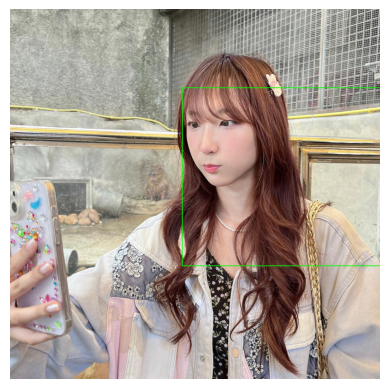

In [ ]:
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torch
from torchvision import transforms

# โหลดรูปภาพ
image_path = "/content/drive/MyDrive/test_images_finetuning/Emmy/383958520_17895526070883513_7485054639864153123_n.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ประมวลผลภาพเพื่อทำนาย
with torch.no_grad():
    model.eval()
    input_batch = input_batch.to(device)
    output = model(input_batch)

# ดึงค่าที่มีความน่าเชื่อถือสูงสุด
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# หากคำตอบที่ทำนายคือใบหน้า (ตั้งค่าให้ตรงกับค่าของคลาสที่คุณต้องการตรวจจับ)
if predicted_class == 0:
    # ใช้ MTCNN จาก facenet-pytorch
    mtcnn = MTCNN(keep_all=True, device=device)

    # ทำให้รูปภาพเป็น grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)  # เพิ่มมิติสี

    # ให้ model ตรวจจับใบหน้า
    boxes, probs = mtcnn.detect(gray_image)

    # วาด bounding box หรือจุดตรวจจับบนภาพ
    if boxes is not None:
        for box in boxes:
            x, y, w, h = [int(coord) for coord in box]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # วาด bounding box

    # แสดงภาพ
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("The predicted class is not a face.")


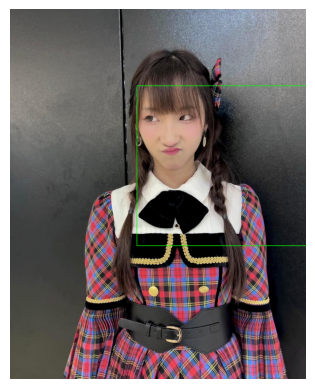

In [ ]:
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torch
from torchvision import transforms

# โหลดรูปภาพ
image_path = "/content/drive/MyDrive/test_images_finetuning/Emmy/400013666_17901914264883513_7390975502636770246_n.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ประมวลผลภาพเพื่อทำนาย
with torch.no_grad():
    model.eval()
    input_batch = input_batch.to(device)
    output = model(input_batch)

# ดึงค่าที่มีความน่าเชื่อถือสูงสุด
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# หากคำตอบที่ทำนายคือใบหน้า (ตั้งค่าให้ตรงกับค่าของคลาสที่คุณต้องการตรวจจับ)
if predicted_class == 0:
    # ใช้ MTCNN จาก facenet-pytorch
    mtcnn = MTCNN(keep_all=True, device=device)

    # ทำให้รูปภาพเป็น grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)  # เพิ่มมิติสี

    # ให้ model ตรวจจับใบหน้า
    boxes, probs = mtcnn.detect(gray_image)

    # วาด bounding box หรือจุดตรวจจับบนภาพ
    if boxes is not None:
        for box in boxes:
            x, y, w, h = [int(coord) for coord in box]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # วาด bounding box

    # แสดงภาพ
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("The predicted class is not a face.")


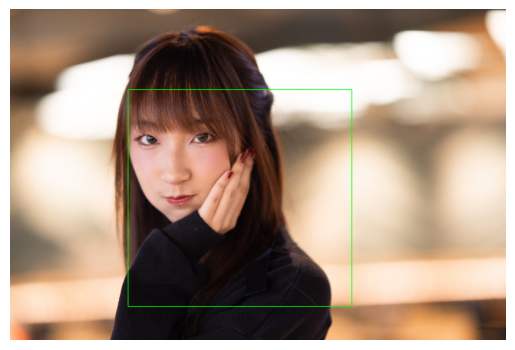

In [ ]:
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torch
from torchvision import transforms

# โหลดรูปภาพ
image_path = "/content/drive/MyDrive/test_images_finetuning/Emmy/F-5khVnXoAAhQLV.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ประมวลผลภาพเพื่อทำนาย
with torch.no_grad():
    model.eval()
    input_batch = input_batch.to(device)
    output = model(input_batch)

# ดึงค่าที่มีความน่าเชื่อถือสูงสุด
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# หากคำตอบที่ทำนายคือใบหน้า (ตั้งค่าให้ตรงกับค่าของคลาสที่คุณต้องการตรวจจับ)
if predicted_class == 0:
    # ใช้ MTCNN จาก facenet-pytorch
    mtcnn = MTCNN(keep_all=True, device=device)

    # ทำให้รูปภาพเป็น grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)  # เพิ่มมิติสี

    # ให้ model ตรวจจับใบหน้า
    boxes, probs = mtcnn.detect(gray_image)

    # วาด bounding box หรือจุดตรวจจับบนภาพ
    if boxes is not None:
        for box in boxes:
            x, y, w, h = [int(coord) for coord in box]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # วาด bounding box

    # แสดงภาพ
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("The predicted class is not a face.")


In [ ]:
!dir /content/drive/MyDrive/test_images_finetuning_CNNScratch/train

Emmy  Fond  L  Nana  Paeyah


In [ ]:
!dir /content/drive/MyDrive/test_images_finetuning_CNNScratch/valid

Emmy  Fond  L  Nana  Paeyah


### New By Nattawut Kaowsaard

In [ ]:
len(train_generator.class_indices)

5

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# กำหนดขนาดของภาพที่ใช้ในการ train
image_size = (128, 128)
batch_size = 128

# กำหนดตำแหน่งของ dataset
train_dir = '/content/drive/MyDrive/test_images_finetuning_CNNScratch/train'
valid_dir = '/content/drive/MyDrive/test_images_finetuning_CNNScratch/valid'

# สร้าง Generator สำหรับการ augment ข้อมูลในชุดฝึกสอน
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# สร้าง Generator สำหรับชุดทดสอบ
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# สร้างโมเดล CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# คอมไพล์โมเดล
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ฝึกโมเดล
model.fit(train_generator,
          epochs=20,
          validation_data=valid_generator)

Found 35 images belonging to 5 classes.
Found 15 images belonging to 5 classes.
Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 1.6062 - accuracy: 0.2000 - val_loss: 1.6119 - val_accuracy: 0.2000
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 1.5942 - accuracy: 0.1714 - val_loss: 1.6095 - val_accuracy: 0.2667
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 1.6249 - accuracy: 0.1429 - val_loss: 1.6119 - val_accuracy: 0.2667
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 1.5875 - accuracy: 0.2000 - val_loss: 1.6144 - val_accuracy: 0.2667
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 1.6092 - accuracy: 0.1714 - val_loss: 1.6153 - val_accuracy: 0.2667
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1.5960 - accuracy: 0.2000 - val_loss: 1.6143 - val_accuracy: 0.2000
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 1.6134 - accuracy: 0.1429 - v

In [ ]:
# ดึงค่า class indices จาก generator ที่ใช้ในการฝึก
class_indices = train_generator.class_indices

# สร้าง reverse mapping เพื่อดึงชื่อ class จาก index
reverse_class_mapping = {v: k for k, v in class_indices.items()}

# แสดง label class ทั้งหมด
label_classes = list(reverse_class_mapping.values())
print("Label Classes:", label_classes)


Label Classes: ['Emmy', 'Fond', 'L', 'Nana', 'Paeyah']


In [ ]:
# บันทึกโมเดล
model.save('face_detection_model.h5')

1/1 [==============================] - 0s 134ms/step


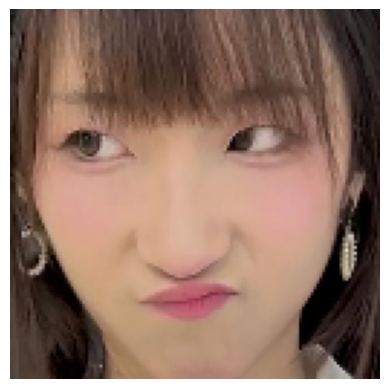

1/1 [==============================] - 0s 30ms/step


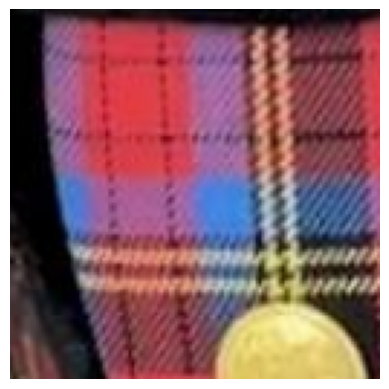

1/1 [==============================] - 0s 19ms/step


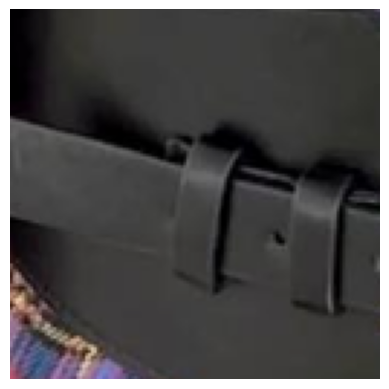

1/1 [==============================] - 0s 19ms/step


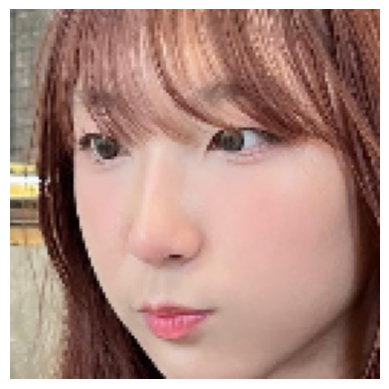

1/1 [==============================] - 0s 18ms/step


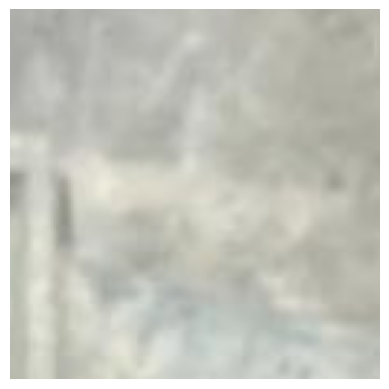

1/1 [==============================] - 0s 21ms/step


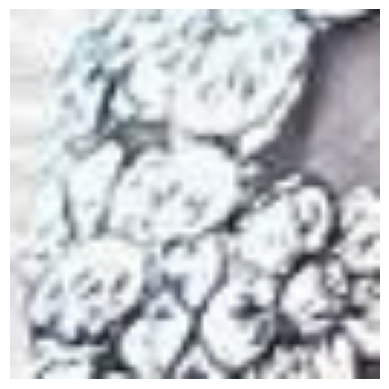

1/1 [==============================] - 0s 19ms/step


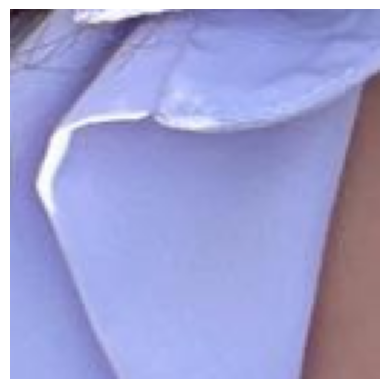

1/1 [==============================] - 0s 28ms/step


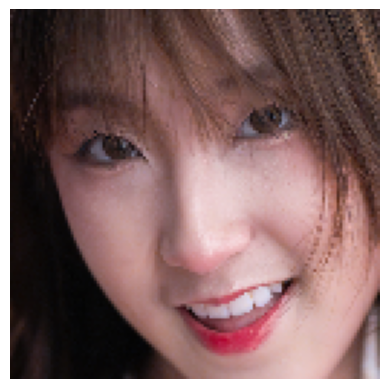

1/1 [==============================] - 0s 21ms/step


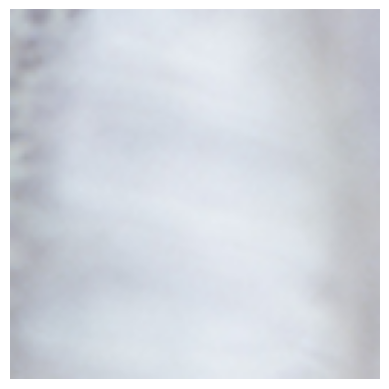

1/1 [==============================] - 0s 20ms/step


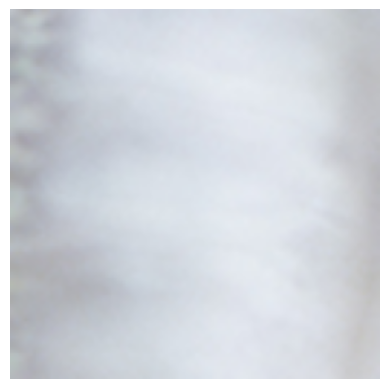

1/1 [==============================] - 0s 20ms/step


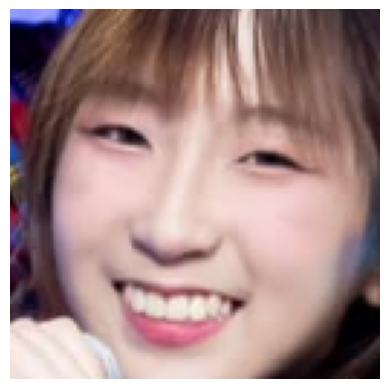

1/1 [==============================] - 0s 18ms/step


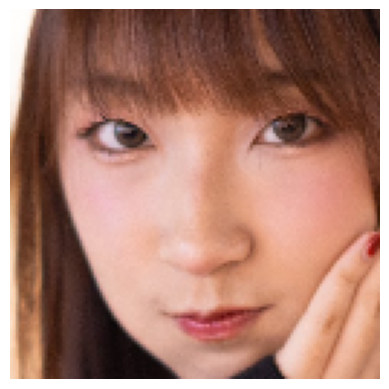

1/1 [==============================] - 0s 28ms/step


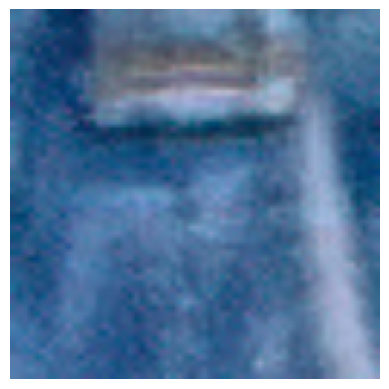

ชื่อ label ที่ทำนายได้: ['Emmy', 'Emmy', 'Emmy', 'Emmy', 'Emmy', 'Emmy', 'Emmy', 'Paeyah', 'Emmy', 'Emmy', 'Paeyah', 'Emmy', 'Emmy']


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# โหลด pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# โหลดโมเดลที่ฝึกอบรม
model = tf.keras.models.load_model('face_detection_model.h5')

# กำหนด path ของโฟลเดอร์ที่มีภาพที่ต้องการทดสอบ
test_path = '/content/drive/MyDrive/test_images_finetuning/Emmy'

# สร้าง list เพื่อเก็บชื่อ label ที่ทำนายได้
predicted_labels = []

# วนลูปทุกภาพในโฟลเดอร์ทดสอบ
for filename in os.listdir(test_path):
    img_path = os.path.join(test_path, filename)
    img_cv2 = cv2.imread(img_path)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)  # แปลง BGR เป็น RGB (สำหรับ OpenCV)

    # ทำ face detection
    faces = face_cascade.detectMultiScale(img_cv2, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # ถ้ามีหน้าถูกตรวจจับ
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # ดึงและประมวลผลเฉพาะส่วนที่มีใบหน้า
            face_img = img_cv2[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, image_size)  # ปรับขนาดเพื่อให้เข้ากับโมเดล

            # ทำนายคลาส
            face_img_array = np.expand_dims(face_img, axis=0).astype('float32')
            face_img_array /= 255.0  # ทำให้ค่า pixel อยู่ในช่วง [0, 1]
            prediction = model.predict(face_img_array)
            predicted_class = train_generator.class_indices
            predicted_label = list(predicted_class.keys())[np.argmax(prediction)]

            # เพิ่มชื่อ label ที่ทำนายได้ลงใน list
            predicted_labels.append(predicted_label)

            # แสดงภาพพร้อมกับการตรวจจับใบหน้า
            plt.imshow(face_img)
            plt.axis('off')
            plt.show()

# แสดงผลลัพธ์
if len(predicted_labels) == 0:
    print("ไม่พบภาพในโฟลเดอร์ทดสอบ")
else:
    print("ชื่อ label ที่ทำนายได้:", predicted_labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# กำหนดตำแหน่งของ dataset
train_dir = '/content/drive/MyDrive/test_images_finetuning_CNNScratch/train'
valid_dir = '/content/drive/MyDrive/test_images_finetuning_CNNScratch/valid'

# กำหนดขนาดของภาพที่ใช้ในการ train
image_size = (128, 128)
batch_size = 128

# สร้าง Generator สำหรับการ augment ข้อมูลในชุดฝึกสอน
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# สร้าง Generator สำหรับชุดทดสอบ
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# สร้างโมเดล CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

Found 35 images belonging to 5 classes.
Found 15 images belonging to 5 classes.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 128)      

จาก Model ที่ Build มาจากทั้ง 2 คน <br>
เห็นได้ว่า ที่ Best Case <br>
ได้ Training Accuracy ที่ 22.857% <br>
และ Validation Accuracy ที่ 20% <br>
และมีการทายผิดไปบ้าง (ป้อนรูป Emmy ไป แต่มีทายได้ Paeyah บ้าง)

เมื่อเทียบกับ Model สำเร็จรูปแล้ว <br>
จะมีประสิทธิภาพดีกว่า <br>
ด้วย Training Accuracy = 1.0000 (ประมาณ 100%)<br>
และ Valid Accuracy = 0.8000 (ประมาณ 80%)